In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy as dc
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

           Date        Open        High         Low       Close   Adj Close  \
0    2022-07-27  263.809998  275.926666  261.790009  274.820007  274.820007   
1    2022-07-28  280.066681  283.299988  272.799988  280.899994  280.899994   
2    2022-07-29  280.700012  298.320007  279.100006  297.149994  297.149994   
3    2022-08-01  301.276672  311.876678  295.000000  297.276672  297.276672   
4    2022-08-02  294.003326  307.833344  292.666656  300.586670  300.586670   
..          ...         ...         ...         ...         ...         ...   
246  2023-07-20  279.559998  280.929993  261.200012  262.899994  262.899994   
247  2023-07-21  268.000000  268.000000  255.800003  260.019989  260.019989   
248  2023-07-24  255.850006  269.850006  254.119995  269.059998  269.059998   
249  2023-07-25  272.380005  272.899994  265.000000  265.279999  265.279999   
250  2023-07-26  263.250000  268.040009  261.750000  264.350006  264.350006   

        Volume  
0     88110000  
1     84723000  


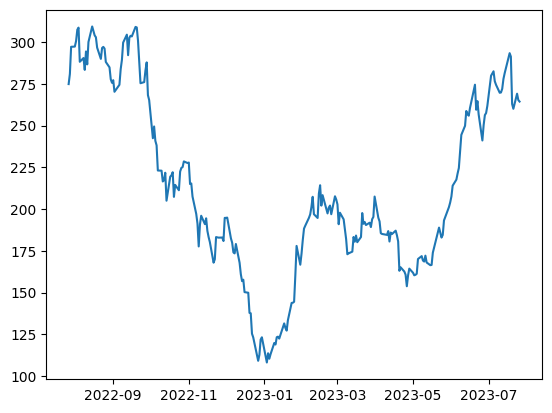

In [ ]:
StockDat = pd.read_csv('TSLA (1).csv')
print(StockDat)


StockDat = StockDat[['Date','Close']]
print(StockDat)


StockDat['Date'] = pd.to_datetime(StockDat['Date'])
plt.plot(StockDat['Date'],StockDat['Close'])

In [ ]:
def PrepData(StockDat,n_steps):
    StockDat = dc(StockDat)

    StockDat.set_index('Date', inplace = True)

    for i in range(1,n_steps+1):
        StockDat[f'Close(t-{i})']= StockDat["Close"].shift(i)
    StockDat.dropna(inplace=True)
    return StockDat
lookback = 7
StockShiftedDat = PrepData(StockDat,lookback)
StockShiftedDat

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
2022-08-05,288.170013,308.633331,307.396667,300.586670,297.276672,297.149994,280.899994,274.820007
2022-08-08,290.423340,288.170013,308.633331,307.396667,300.586670,297.276672,297.149994,280.899994
2022-08-09,283.333344,290.423340,288.170013,308.633331,307.396667,300.586670,297.276672,297.149994
2022-08-10,294.356659,283.333344,290.423340,288.170013,308.633331,307.396667,300.586670,297.276672
2022-08-11,286.630005,294.356659,283.333344,290.423340,288.170013,308.633331,307.396667,300.586670
...,...,...,...,...,...,...,...,...
2023-07-20,262.899994,291.260010,293.339996,290.380005,281.380005,277.899994,271.989990,269.790009
2023-07-21,260.019989,262.899994,291.260010,293.339996,290.380005,281.380005,277.899994,271.989990
2023-07-24,269.059998,260.019989,262.899994,291.260010,293.339996,290.380005,281.380005,277.899994


In [ ]:
NpShiftedStock = StockShiftedDat.to_numpy()
NpShiftedStock

Scaler = MinMaxScaler(feature_range=(-1,1))
NpShiftedStock = Scaler.fit_transform(NpShiftedStock)
NpShiftedStock

array([[0.7897824 , 0.99317487, 0.98088321, ..., 0.87903775, 0.71752299,
        0.65709176],
       [0.81217905, 0.7897824 , 0.99317487, ..., 0.88029684, 0.87903775,
        0.71752299],
       [0.74170896, 0.81217905, 0.7897824 , ..., 0.91319614, 0.88029684,
        0.87903775],
       ...,
       [0.5998409 , 0.50998891, 0.53861434, ..., 0.81174832, 0.722294  ,
        0.68770488],
       [0.56227009, 0.5998409 , 0.50998891, ..., 0.84116877, 0.81174832,
        0.722294  ],
       [0.55302655, 0.56227009, 0.5998409 , ..., 0.82049502, 0.84116877,
        0.81174832]])

In [ ]:
X = NpShiftedStock[:,1:]
Y = NpShiftedStock[:, 0]

X.shape, Y.shape
X= dc(np.flip(X,axis=1))
X

array([[0.65709176, 0.71752299, 0.87903775, ..., 0.91319614, 0.98088321,
        0.99317487],
       [0.71752299, 0.87903775, 0.88029684, ..., 0.98088321, 0.99317487,
        0.7897824 ],
       [0.87903775, 0.88029684, 0.91319614, ..., 0.99317487, 0.7897824 ,
        0.81217905],
       ...,
       [0.68770488, 0.722294  , 0.81174832, ..., 0.82049502, 0.53861434,
        0.50998891],
       [0.722294  , 0.81174832, 0.84116877, ..., 0.53861434, 0.50998891,
        0.5998409 ],
       [0.81174832, 0.84116877, 0.82049502, ..., 0.50998891, 0.5998409 ,
        0.56227009]])

In [ ]:
split_index = int(len(X)*0.95)
split_index

TrainX = X[:split_index]
TestX = X[split_index:]

TrainY = Y[:split_index]
TestY = Y[split_index:]

TrainX = TrainX.reshape((-1, lookback , 1 ))
TestX = TestX.reshape((-1, lookback, 1))

TrainY = TrainY.reshape((-1 , 1))
TestY = TestY.reshape((-1, 1))

### Lets just Wrap this Stuff in Pytorch Tensor ###

TestX = torch.tensor(TestX).float()
TrainX = torch.tensor(TrainX).float()
TrainY = torch.tensor(TrainY).float()
TestY = torch.tensor(TestY).float()

In [ ]:
class TimeSeriesData(Dataset):
    def __init__(self,X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.Y[i]

Train_Data = TimeSeriesData(TrainX, TrainY)
Test_Data = TimeSeriesData(TestX, TestY)

In [ ]:
print(type(TrainX))
print(len(TrainX))

print(type(TrainY))
print(len(TrainY))

print(type(TestX))
print(len(TestX))

print(type(TestY))
print(len(TestY))

<class 'torch.Tensor'>
231
<class 'torch.Tensor'>
231
<class 'torch.Tensor'>
13
<class 'torch.Tensor'>
13


In [ ]:
batch_size = 16

TrainLoader = DataLoader(Train_Data, batch_size= batch_size, shuffle=True)
TestLoader = DataLoader(Test_Data, batch_size=batch_size,shuffle=False)

In [ ]:
for _, batch in enumerate(TrainLoader):
    BatchX, BatchY = batch[0].to(device), batch[1].to(device)
    print(BatchX.shape, BatchY.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm1 = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                             batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, num_stacked_layers,
                             batch_first=True)

        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm1(x, (h0, c0))
        out, _ = self.lstm2(out)
        out = F.relu(self.fc1(out[:, -1, :]))
        out = self.fc2(out)
        return out

model = LSTM(1, 4, 2)
model.to(device)

# Changing the optimizer to SGD
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [ ]:
def EpochOneT():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    RunLoss = 0.0

    for batch_index, batch in enumerate (TrainLoader):
        BatchX, BatchY = batch[0].to(device), batch[1].to(device)

        Output = model(BatchX)
        loss = LossFunc(Output, BatchY)
        RunLoss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:
            avg_loss_across_batches = RunLoss/100
            print('Batch{0}, loss: {1:.3f})'.format(batch_index+1,
                                                    avg_loss_across_batches))
            RunLoss = 0.0
print(0)

0


In [ ]:
def EpochOneVal():
    model.train(False)
    Runloss = 0.0

    for batch_index, batch in enumerate(TestLoader):
        BatchX, BatchY = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(BatchX)
            loss = LossFunc(output,BatchY)
            Runloss += loss.item()

    avg_loss_across_batches  = Runloss/ len (TestLoader)

    print('Validation Loss {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************')
    print()
    return avg_loss_across_batches

In [ ]:
LearnRate = 0.001
NumEpoch = 100
LossFunc = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr= LearnRate)

In [ ]:
# The patience is the number of epochs to wait to see if the validation loss improves
patience = 20
# best_val_loss will hold the best validation loss achieved so far
best_val_loss = np.inf
# patience_counter will keep track of how many epochs have passed since the validation loss improved
patience_counter = 0

for epoch in range(NumEpoch):
    EpochOneT()
    val_loss = EpochOneVal()

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter > patience:
        print("Stopping training due to early stopping")
        break

Epoch: 1
Validation Loss 0.382
***************************************

Epoch: 2
Validation Loss 0.417
***************************************

Epoch: 3
Validation Loss 0.422
***************************************

Epoch: 4
Validation Loss 0.439
***************************************

Epoch: 5
Validation Loss 0.448
***************************************

Epoch: 6
Validation Loss 0.444
***************************************

Epoch: 7
Validation Loss 0.427
***************************************

Epoch: 8
Validation Loss 0.430
***************************************

Epoch: 9
Validation Loss 0.398
***************************************

Epoch: 10
Validation Loss 0.338
***************************************

Epoch: 11
Validation Loss 0.257
***************************************

Epoch: 12
Validation Loss 0.156
***************************************

Epoch: 13
Validation Loss 0.087
***************************************

Epoch: 14
Validation Loss 0.046
****************************

In [ ]:
for epoch in range(NumEpoch):
    EpochOneT()
    EpochOneVal()
with torch.no_grad():
    predicted = model(TrainX.to(device)).to('cpu').numpy()

Epoch: 1
Validation Loss 0.015
***************************************

Epoch: 2
Validation Loss 0.015
***************************************

Epoch: 3
Validation Loss 0.015
***************************************

Epoch: 4
Validation Loss 0.015
***************************************

Epoch: 5
Validation Loss 0.017
***************************************

Epoch: 6
Validation Loss 0.015
***************************************

Epoch: 7
Validation Loss 0.015
***************************************

Epoch: 8
Validation Loss 0.016
***************************************

Epoch: 9
Validation Loss 0.015
***************************************

Epoch: 10
Validation Loss 0.015
***************************************

Epoch: 11
Validation Loss 0.016
***************************************

Epoch: 12
Validation Loss 0.015
***************************************

Epoch: 13
Validation Loss 0.015
***************************************

Epoch: 14
Validation Loss 0.016
****************************

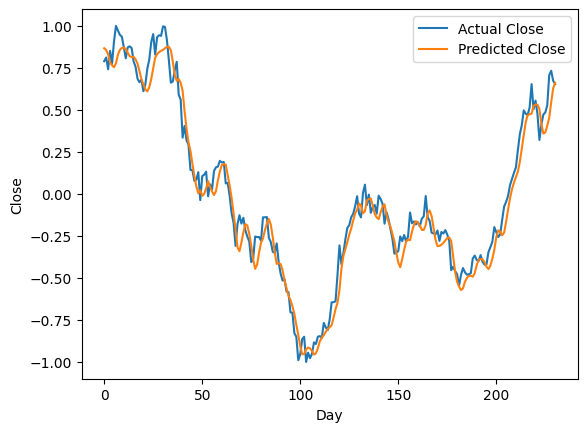

In [ ]:
plt.plot(TrainY, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler


In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load your data
df = pd.read_csv('TSLA (1).csv')

# Create a scaler object
scaler = MinMaxScaler(feature_range=(-1, 1))

# Fit the scaler to the 'Close' column of your data
scaler.fit(df[['Close']])

# Now you can use this fitted scaler to inverse_transform your predictions
train_predictions = predicted.flatten()
dummies = np.zeros((TrainX.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)  # Use the fitted scaler

train_predictions = dummies[:, 0]
train_predictions

array([295.95017279, 294.94214272, 292.36948142, 287.48825293,
       285.75154284, 284.60045255, 286.93681502, 292.1004939 ,
       294.99677978, 296.14804398, 296.33375361, 295.51501328,
       293.34168046, 291.15561039, 290.67308198, 290.82135344,
       289.41659752, 286.69541888, 282.16276176, 277.26454426,
       274.31776512, 271.2929793 , 270.14122337, 272.66691755,
       277.50850704, 283.98765514, 290.29143213, 292.40974409,
       293.64343463, 294.40930696, 294.98530186, 295.91962497,
       296.87565657, 296.81369139, 294.77424366, 287.9923879 ,
       280.08598379, 276.47209401, 277.57562349, 275.32464979,
       270.50532051, 258.25216082, 247.90681258, 239.66249946,
       234.44768566, 226.72195836, 219.50054442, 213.22489853,
       209.07914747, 210.9594605 , 207.52275886, 208.76718071,
       212.06792836, 216.39286751, 213.02555212, 210.21361756,
       208.06374731, 210.34962252, 216.81712179, 222.07888772,
       226.01052819, 226.53995476, 226.25806208, 219.91

In [ ]:
dummies = np.zeros((TrainX.shape[0], lookback+1))
dummies[:, 0] = TrainY.flatten()
dummies = scaler.inverse_transform(dummies)

NewTrainY = dc(dummies[:, 0])
NewTrainY

array([288.17001381, 290.42333826, 283.33334172, 294.35666084,
       286.63000553, 300.02999777, 309.320007  , 306.56332117,
       303.99667468, 302.86999747, 296.66665528, 289.9133324 ,
       296.45333627, 297.0966815 , 296.07000731, 288.08999819,
       284.82000825, 277.7000096 , 275.60998466, 277.16000164,
       270.20998895, 274.42001097, 283.7000115 , 289.26000846,
       299.67999316, 304.42001445, 292.13000427, 302.60998719,
       303.75000134, 303.35000721, 309.07000542, 308.73000951,
       300.79998992, 288.58999535, 275.32998697, 276.01000877,
       282.94000406, 287.8100005 , 268.20998832, 265.24999817,
       242.39999545, 249.44000247, 240.80999765, 238.1300052 ,
       223.07000674, 222.960007  , 216.50000001, 217.24000504,
       221.72000031, 204.99000492, 219.35000616, 220.19000223,
       222.03999232, 207.27999901, 214.44000191, 211.25000004,
       222.41999754, 224.63999914, 225.08999628, 228.52000396,
       227.53999256, 227.82000674, 214.97999601, 215.30

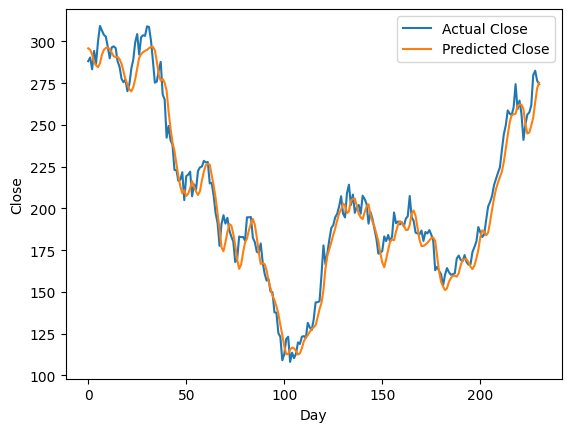

In [ ]:
plt.plot(NewTrainY, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

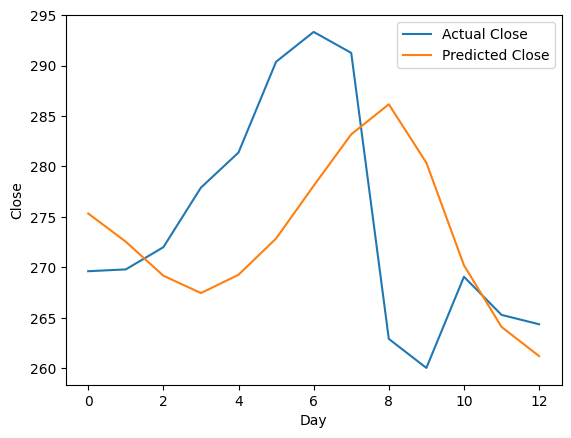

In [ ]:
TestPred = model(TestX.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((TestX.shape[0], lookback+1))
dummies[:, 0] = TestPred
dummies = scaler.inverse_transform(dummies)

TestPred= dc(dummies[:, 0])
TestPred
dummies = np.zeros((TestX.shape[0], lookback+1))
dummies[:, 0] = TestY.flatten()
dummies = scaler.inverse_transform(dummies)

NewTestY = dc(dummies[:, 0])
NewTestY
plt.plot(NewTestY, label='Actual Close')
plt.plot(TestPred, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Compute the error scores on train data
train_mae = mean_absolute_error(NewTrainY, train_predictions)
train_mse = mean_squared_error(NewTrainY, train_predictions)
train_rmse = np.sqrt(train_mse)

# Compute the error scores on test data
test_mae = mean_absolute_error(NewTestY, TestPred)
test_mse = mean_squared_error(NewTestY, TestPred)
test_rmse = np.sqrt(test_mse)

print(f'Training MAE: {train_mae:.2f}')
print(f'Test MAE: {test_mae:.2f}')

print(f'Training RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')

Training MAE: 7.51
Test MAE: 9.53
Training RMSE: 9.38
Test RMSE: 12.02


In [ ]:
from sklearn.linear_model import LinearRegression

# Prepare your data
# In this case, we'll use the 'Close' price from the previous day as our feature
X_train = TrainY[:-1]
y_train = TrainY[1:]
X_test = TestY[:-1]

# Fit the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict the 'Close' prices
pred = model.predict(X_test)

# You can now compare 'pred' with your test set

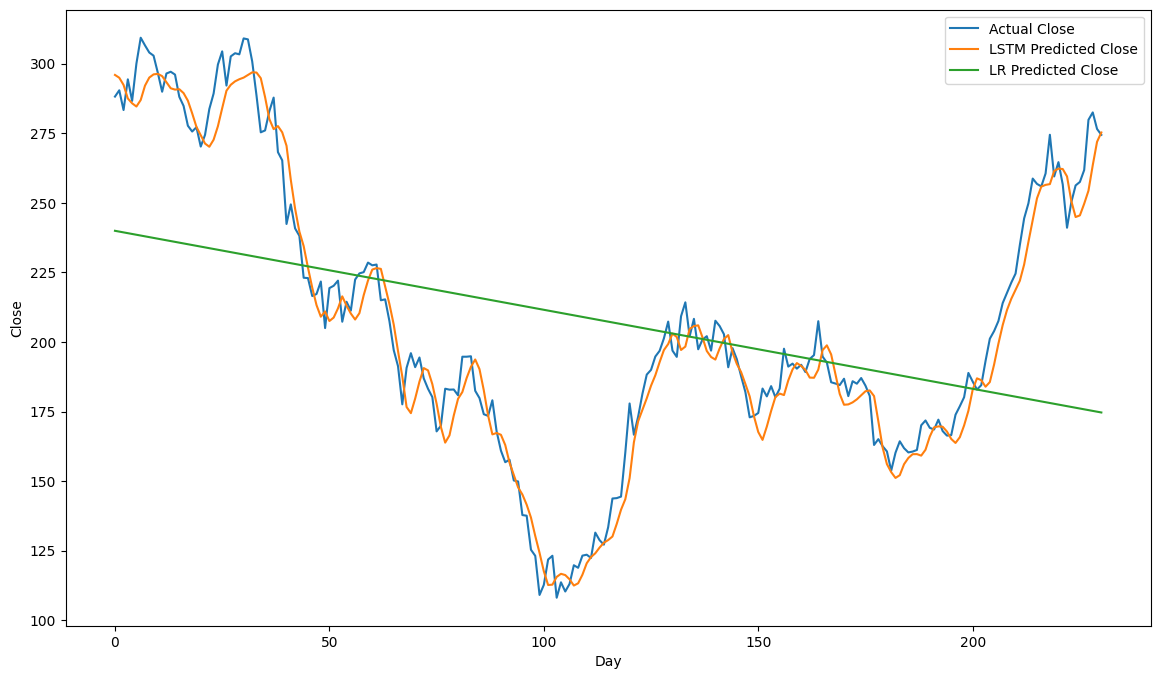

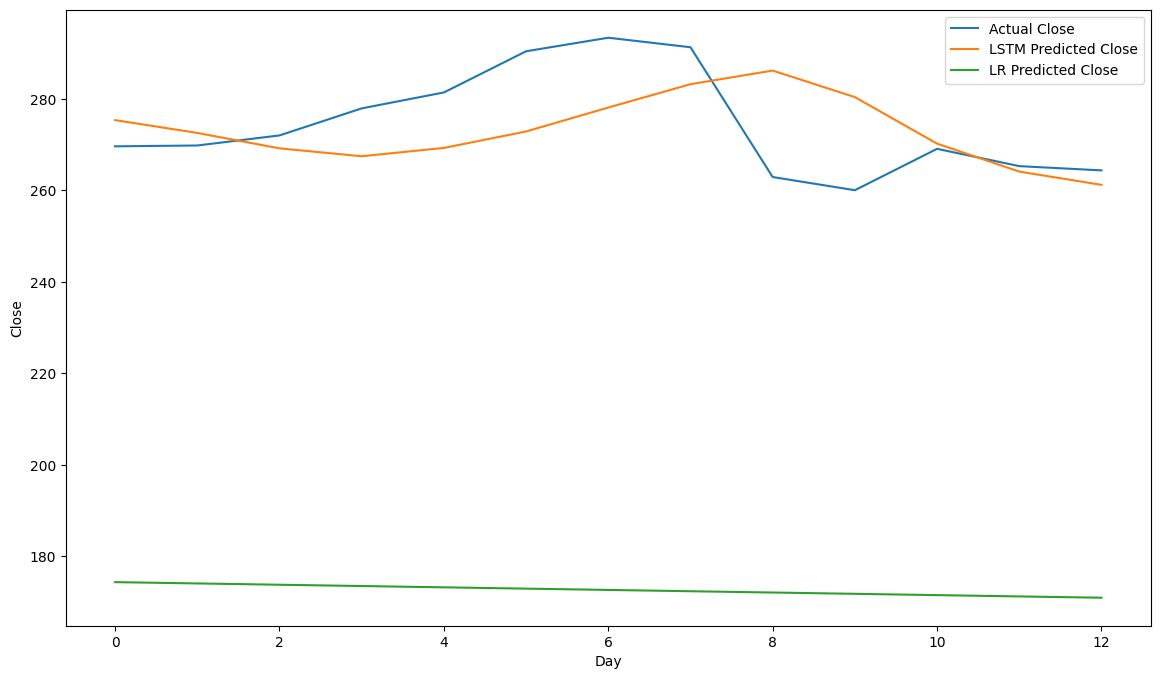

In [ ]:
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
# Preparing data for linear regression
X_lr_train = np.array(range(len(TrainX))).reshape(-1,1)
y_lr_train = NewTrainY  # using actual closing prices for training
X_lr_test = np.array(range(len(TrainX), len(TrainX) + len(TestX))).reshape(-1,1)
y_lr_test = NewTestY  # using actual closing prices for testing

# Training the linear regression model
lr_model = LinearRegression()
lr_model.fit(X_lr_train, y_lr_train)

# Making predictions
lr_train_predictions = lr_model.predict(X_lr_train)
lr_test_predictions = lr_model.predict(X_lr_test)

# Plotting the results
plt.figure(figsize=(14,8))
plt.plot(NewTrainY, label='Actual Close')
plt.plot(train_predictions, label='LSTM Predicted Close')
plt.plot(lr_train_predictions, label='LR Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

# Plotting test predictions
plt.figure(figsize=(14,8))
plt.plot(NewTestY, label='Actual Close')
plt.plot(TestPred, label='LSTM Predicted Close')
plt.plot(lr_test_predictions, label='LR Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


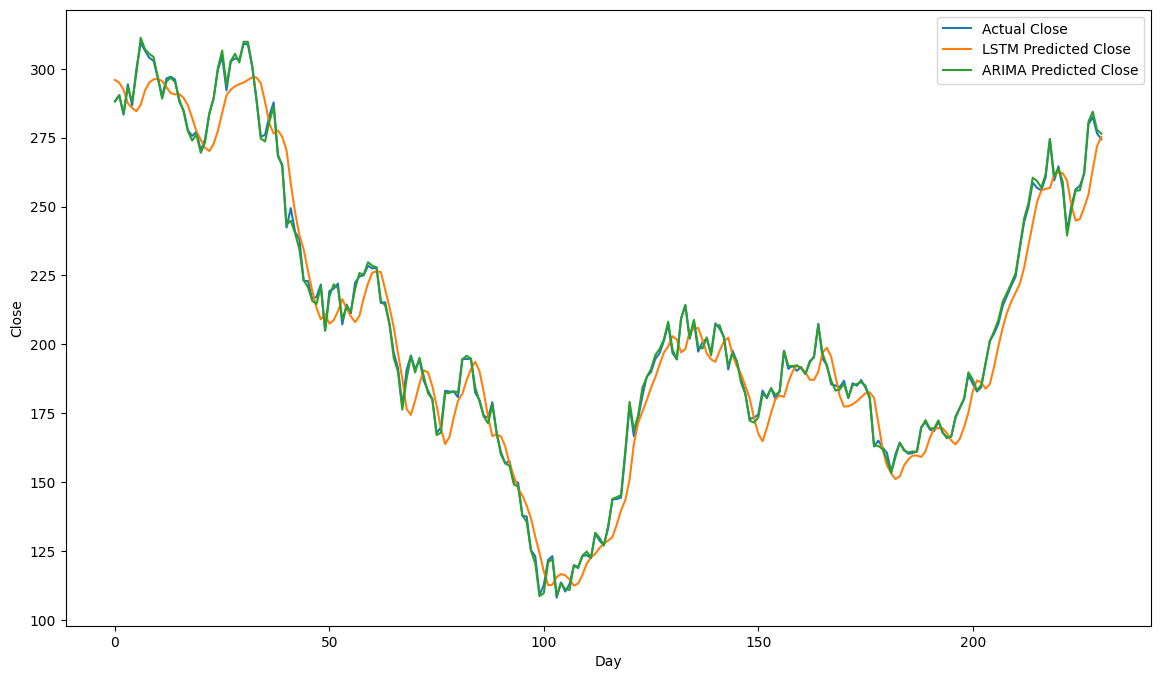

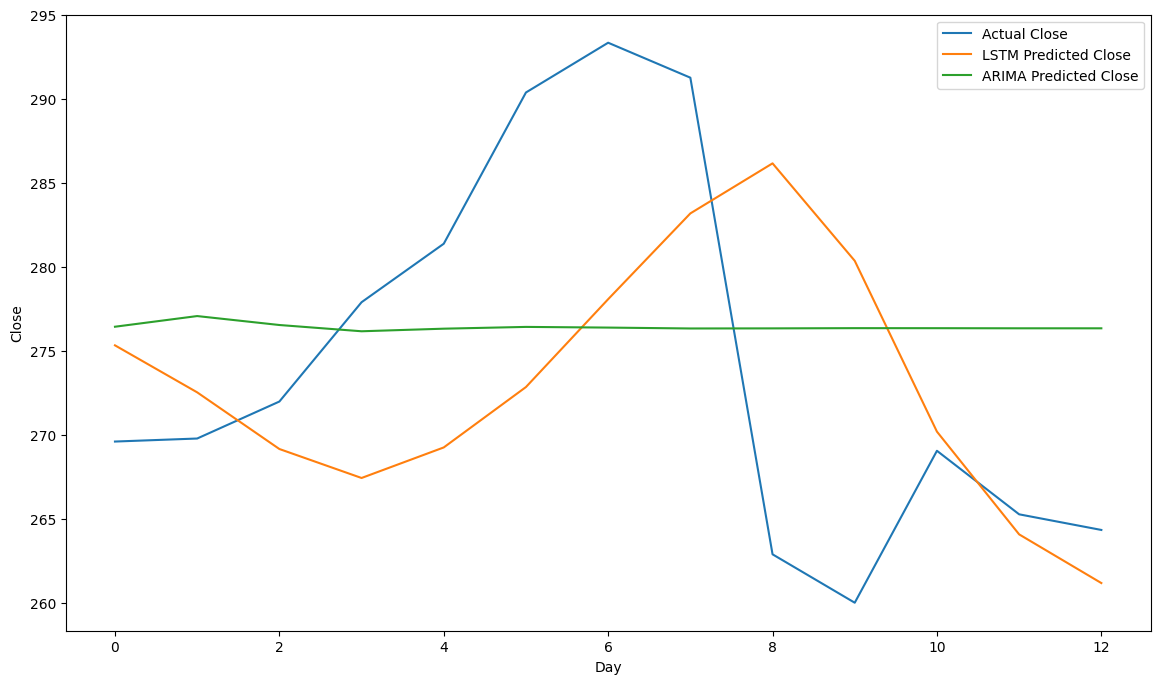

In [ ]:
# Fit ARIMA model (p=5, d=1, q=0)
arima_model = ARIMA(NewTrainY, order=(5,1,0))
arima_model_fit = arima_model.fit()

# Making predictions
arima_train_predictions = arima_model_fit.predict(start=1, end=len(NewTrainY), typ='levels')
arima_test_predictions = arima_model_fit.predict(start=len(NewTrainY), end=len(NewTrainY) + len(NewTestY)-1, typ='levels')

# Plotting train predictions
plt.figure(figsize=(14,8))
plt.plot(NewTrainY, label='Actual Close')
plt.plot(train_predictions, label='LSTM Predicted Close')
plt.plot(arima_train_predictions, label='ARIMA Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

# Plotting test predictions
plt.figure(figsize=(14,8))
plt.plot(NewTestY, label='Actual Close')
plt.plot(TestPred, label='LSTM Predicted Close')
plt.plot(arima_test_predictions, label='ARIMA Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [ ]:
# For Linear Regression
train_mae_lr = mean_absolute_error(NewTrainY, lr_train_predictions)
train_mse_lr = mean_squared_error(NewTrainY, lr_train_predictions)
train_rmse_lr = np.sqrt(train_mse_lr)

test_mae_lr = mean_absolute_error(NewTestY, lr_test_predictions)
test_mse_lr = mean_squared_error(NewTestY, lr_test_predictions)
test_rmse_lr = np.sqrt(test_mse_lr)

# For LSTM
train_mae_lstm = mean_absolute_error(NewTrainY, train_predictions)
train_mse_lstm = mean_squared_error(NewTrainY, train_predictions)
train_rmse_lstm = np.sqrt(train_mse_lstm)

test_mae_lstm = mean_absolute_error(NewTestY, TestPred)
test_mse_lstm = mean_squared_error(NewTestY, TestPred)
test_rmse_lstm = np.sqrt(test_mse_lstm)

# For ARIMA
train_mae_arima = mean_absolute_error(NewTrainY[1:], arima_train_predictions[1:])  # Exclude first element because of differencing (d=1)
train_mse_arima = mean_squared_error(NewTrainY[1:], arima_train_predictions[1:])
train_rmse_arima = np.sqrt(train_mse_arima)

# In test set, if you have the same issue
test_mae_arima = mean_absolute_error(NewTestY[1:], arima_test_predictions[1:])
test_mse_arima = mean_squared_error(NewTestY[1:], arima_test_predictions[1:])
test_rmse_arima = np.sqrt(test_mse_arima)

# Print the metrics
print('Linear Regression:')
print(f'Train MAE: {train_mae_lr}, Train MSE: {train_mse_lr}, Train RMSE: {train_rmse_lr}')
print(f'Test MAE: {test_mae_lr}, Test MSE: {test_mse_lr}, Test RMSE: {test_rmse_lr}')

print('\nLSTM:')
print(f'Train MAE: {train_mae_lstm}, Train MSE: {train_mse_lstm}, Train RMSE: {train_rmse_lstm}')
print(f'Test MAE: {test_mae_lstm}, Test MSE: {test_mse_lstm}, Test RMSE: {test_rmse_lstm}')

print('\nARIMA:')
print(f'Train MAE: {train_mae_arima}, Train MSE: {train_mse_arima}, Train RMSE: {train_rmse_arima}')
print(f'Test MAE: {test_mae_arima}, Test MSE: {test_mse_arima}, Test RMSE: {test_rmse_arima}')

Linear Regression:
Train MAE: 37.134333484152876, Train MSE: 2288.7196203573662, Train RMSE: 47.84056459070447
Test MAE: 101.7297965673897, Test MSE: 10463.367566687308, Test RMSE: 102.29060351120873

LSTM:
Train MAE: 7.50579757459194, Train MSE: 87.98482777790386, Train RMSE: 9.380022802632404
Test MAE: 9.525678862766878, Test MSE: 144.4236742566689, Test RMSE: 12.017640128439066

ARIMA:
Train MAE: 0.9765778259284227, Train MSE: 1.5232588788553365, Train RMSE: 1.234203742846106
Test MAE: 10.382098275668355, Test MSE: 131.18180498945094, Test RMSE: 11.45346257641989


In [ ]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import SGD as LegacySGD
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
# Prepare the LogReturn series
df['LogReturn'] = np.log(StockDat['Close']) - np.log(StockDat['Close'].shift(1))
df.dropna(inplace=True)

# Create a new dataframe with only 'LogReturn' column
data = df.filter(['LogReturn'])

# Convert dataframe to numpy array
dataset = data.values

# Get the number of rows to train the model on (say, 80% of the data)
training_data_len = int(np.ceil(len(dataset) * .8))

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# Create the training data set
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]

# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
   x_train.append(train_data[i-60:i, 0])
   y_train.append(train_data[i, 0])

# Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data into 3-D array
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002
test_data = scaled_data[training_data_len - 60: , :]

# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data to 3-D array since LSTM model expect a 3-D array as input
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Convert y_test to binary
y_test = np.where(y_test > 0, 1, 0)

Epoch 1/5
140/140 [==============================] - 8s 33ms/step - loss: 0.0993
Epoch 2/5
140/140 [==============================] - 4s 26ms/step - loss: 0.0511
Epoch 3/5
140/140 [==============================] - 4s 26ms/step - loss: 0.0531
Epoch 4/5
140/140 [==============================] - 5s 32ms/step - loss: 0.0482
Epoch 5/5
2/2 [==============================] - 1s 15ms/step
Precision: 0.68
Recall: 1.0
AUC-ROC: 0.5


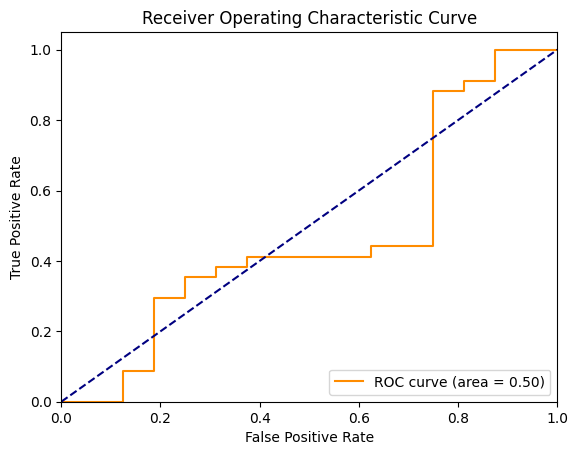

In [ ]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1, activation='sigmoid'))

# Compile the model with SGD optimizer
sgd = LegacySGD(lr=0.01, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='binary_crossentropy')

# Train the model
model.fit(x_train, np.where(y_train > 0, 1, 0), batch_size=1, epochs=5)

# Get the models predicted price values
predictions = model.predict(x_test)

# Convert predictions to binary
binary_predictions = np.where(predictions > 0.5, 1, 0)

# Calculate precision, recall and AUC-ROC
precision = precision_score(y_test, binary_predictions)
recall = recall_score(y_test, binary_predictions)
auc_roc = roc_auc_score(y_test, binary_predictions)

print(f'Precision: {precision}\nRecall: {recall}\nAUC-ROC: {auc_roc}')

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, predictions)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % auc_roc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()